In [39]:
%%capture
!pip install -q transformers
!pip install torch
!pip uninstall opencv-python
!pip install opencv-python-headless

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [40]:
import requests
from PIL import Image
import numpy as np
import torch
import cv2
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import boto3
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import json
import base64
from PIL import Image
from io import BytesIO

## Classes

In [44]:
class masking:
    
    def __init__(self):
        # load model
        self.processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
        self.model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
        
    def load_image(self, img_path):
        # load image
        self.original_image = Image.open(img_path)
        self.image = self.original_image.convert('RGB')
        
        # Convert to PyTorch tensor
        tensor = torch.tensor(np.array(self.image)).permute(2, 0, 1).unsqueeze(0).float()
        
    def pass_prompts(self, prompts):
        # pass prompts as a list
        self.prompts = prompts
        
    def create_masks(self):
        # run to create masks
        inputs = self.processor(text=self.prompts, images=[self.image] * len(self.prompts), padding="max_length", return_tensors="pt")

        # predict
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        i = len(outputs.logits.shape)%2
        
        if i == 0:
            self.preds = outputs.logits.unsqueeze(i).unsqueeze(i)
            self.masks = torch.sigmoid(self.preds).squeeze(i).squeeze(i)
            self.maskss = outputs.logits
            
        else:
            self.preds = outputs.logits.unsqueeze(i)
            self.masks = torch.sigmoid(self.preds).squeeze(i)
            self.maskss = outputs.logits
        
    def plot_images(self, th=0.5, inverse=False):
        # _, axs = plt.subplots(nrows=1, ncols = 3, figsize=(3*(len(self.prompts) + 1), 4))
        self.mask_li = []
        
        for i in range(len(self.prompts)):
                _, axs = plt.subplots(nrows=1, ncols = 3, figsize=(10, 5))
                # plot heatmap
                
                axs[0].axis('off')
                # axs[0].imshow(self.image)
                axs[0].set_title('Heat map')
                axs[0].imshow(torch.sigmoid(self.preds[i, 0, :])) 
                axs[0].text(0, -15, self.prompts[i])
                
                # plot image segment
                
                heat_map = torch.sigmoid(self.preds[i, 0, :]).detach().cpu().numpy()
                # Resize the heat map to match the original image size
                heat_map_resized = cv2.resize(heat_map, (self.image.size[0], self.image.size[1]))
                # Apply a threshold to the heat map to get the mask
                if inverse:
                    mask = (heat_map_resized < th).astype(np.uint8)
                else:
                    mask = (heat_map_resized > th).astype(np.uint8)
                
                self.mask_li.append(mask)
                # Apply the mask to the original image
                masked_image = cv2.bitwise_and(np.array(self.image), np.array(self.image), mask=mask)
                axs[1].axis('off')
                axs[1].set_title('Segmented part')
                axs[1].imshow(masked_image)
                
                # plot binary image
                
                axs[2].set_title('Mask')
                axs[2].axis('off')
                axs[2].imshow(mask,cmap='gray')
                
    def save_fig(self, save_path):
        for i, item in enumerate(self.prompts):
            mask = self.mask_li[i]
            im = Image.fromarray(mask*255, mode="L")
            im.save(os.path.join(save_path, item + '.jpg'))

In [45]:
class diffusion_model:
    
    def __init__(self):
        self.endpoint_name = 'jumpstart-dft-stable-diffusion-2-inpainting'
        
    def encode_img(self, img_name):
        with open(img_name,'rb') as f: img_bytes = f.read()
        encoded_img = base64.b64encode(bytearray(img_bytes)).decode()
        return encoded_img
    
    def encoded_input_image(self, enc_img):
        self.encoded_input = self.encode_img(enc_img)
        
    def encoded_mask_image(self, enc_img):
        self.encoded_mask = self.encode_img(enc_img)
    
    def query_endpoint(self, payload):
        """query the endpoint with the json payload encoded in utf-8 format."""
        encoded_payload = json.dumps(payload).encode('utf-8')
        client = boto3.client('runtime.sagemaker')
        # Accept = 'application/json;jpeg' returns the jpeg image as bytes encoded by base64.b64 encoding.
        # To receive raw image with rgb value set Accept = 'application/json'
        # To send raw image, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
        # Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.
        self.response = client.invoke_endpoint(EndpointName=self.endpoint_name, ContentType='application/json;jpeg', Accept = 'application/json;jpeg', Body=encoded_payload)
        self.response_dict = json.loads(self.response['Body'].read())
        
    def display_image(self, img, title):
        plt.figure(figsize=(3, 3))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.title(title)
        plt.show()
        
    def parse_and_display_response(self):
        """Parse the endpoint response and display the generated images"""

        # response_dict = json.loads(self.response['Body'].read())
        generated_images = self.response_dict['generated_images']

        for generated_image in generated_images:
            with BytesIO(base64.b64decode(generated_image.encode())) as generated_image_decoded:
                with Image.open(generated_image_decoded) as generated_image_np:
                    generated_image_rgb = generated_image_np.convert("RGB")
                    self.display_image(generated_image_rgb, "Inpainted Image")


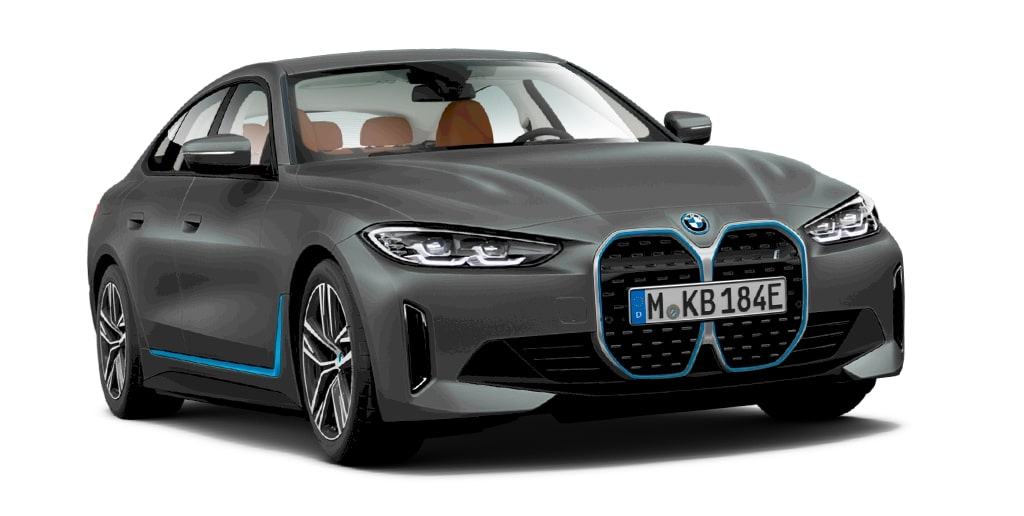

In [46]:
m = masking()
m.load_image('/root/gucci-tutorial/imagesbmw.jpg')
m.original_image

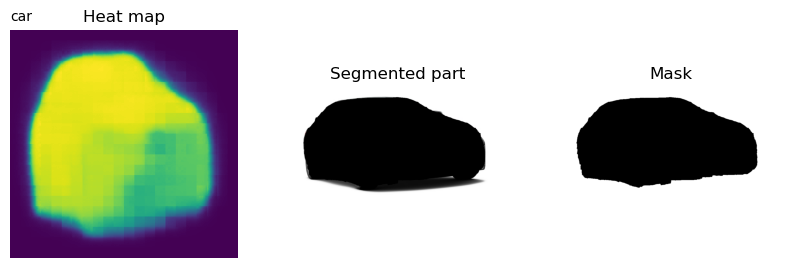

In [63]:
m.pass_prompts(['car'])
m.create_masks()
m.plot_images(th=0.55, inverse=True)

In [64]:
m.save_fig('/root/gucci-tutorial/images')

In [65]:
model = diffusion_model()
model.encoded_input_image('/root/gucci-tutorial/images/bmw.jpg')
model.encoded_mask_image('/root/gucci-tutorial/images/car.jpg')
encoded_input_image = model.encoded_input
encoded_mask_image = model.encoded_mask

In [72]:
payload = { 
    "prompt":"car driving on a road in the near the sea",
    "image":encoded_input_image, 
    "mask_image":encoded_mask_image, 
    "num_inference_steps":100,
    "guidance_scale":7.5,
    "num_images_per_prompt":4,
    "seed": 1,
    "batch_size":2
}

In [73]:
model.query_endpoint(payload)

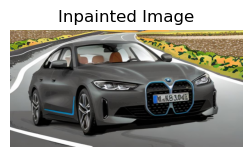

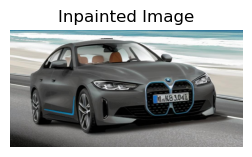

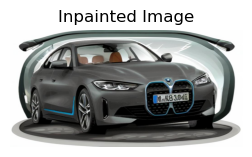

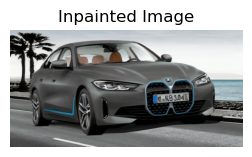

In [74]:
model.parse_and_display_response()